# Visualization notebook for deblending and interpolation examples

### Author: F. Brandolin

- This notebook reproduces the figure of deblending and interpolation sections of the paper.

- The notebooks leverages the PINNslope results saved in the folder precomputed_results to reproduce the figures. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from scipy import signal, ndimage
import matplotlib
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import pylops

from signal_sep_pinns.utils import *
from signal_sep_pinns.plotting import *

plotting_style()

In [3]:
deblending = {'dir':'../data/deblending/gom_blend.npy',
            'ox': 0, 'dx': 26.7, 'nx': 180, 
            'ot': 450, 'dt': 0.004, 'nt': 800+450,
            'nsub':1,
            'epochs':2000,
            'lamda':1000,
            'slope_constraint':-1,
            'n_outputs':2
            }

interp_synth_data = {'dir':'../data/interpolation/synth/seam_shot_15Hz.npy',
            'ox': 0, 'dx':10, 'nx':300, 
            'ot':850, 'dt':0.004, 'nt':1750,
            'nsub':3,
            'epochs':2000,
            'lamda':1000,
            'slope_constraint':-1,
            'n_outputs':2
            }

interp_field_data = {'dir':'../data/interpolation/field/gom_dips.npy',
            'ox': 0, 'dx': 26.7, 'nx': 180, 
            'ot': 560, 'dt': 0.004, 'nt': 340+560,
            'nsub':2,
            'epochs':2000,
            'lamda':1000,
            'slope_constraint':-1,
            'n_outputs':2
            }

# Deblending

In [3]:
# Load the data:
par = deblending
data = np.load(par['dir'])
print('Data shape:',data.shape)

# Data dimensions:
ox, dx,  nx = par['ox'], par['dx'], par['nx']
ot, dt, nt = par['ot'], par['dt'], par['nt']
dim_x = int(nx-ox); dim_t = int(nt-ot) 
x = (np.arange(dim_x)+ ox)* dx
x = np.reshape(x, (dim_x, 1) )
t = ((np.arange(dim_t)+ ot) * dt)*1e3
t = np.reshape(t, (dim_t, 1) )

pinnslope_u = np.load('../data/precomputed_results/deblending/single_out_pinnslope/u.npy')
pinnslope_slope = np.load("../data/precomputed_results/deblending/single_out_pinnslope/slope.npy")
u1 = np.load("../data/precomputed_results/deblending/u1.npy")
u2 = np.load('../data/precomputed_results/deblending/u2.npy')
slope1 = np.load('../data/precomputed_results/deblending/slope1.npy')
slope2 = np.load("../data/precomputed_results/deblending/slope2.npy")
u1u2 = u1+u2

Data shape: (800, 180)


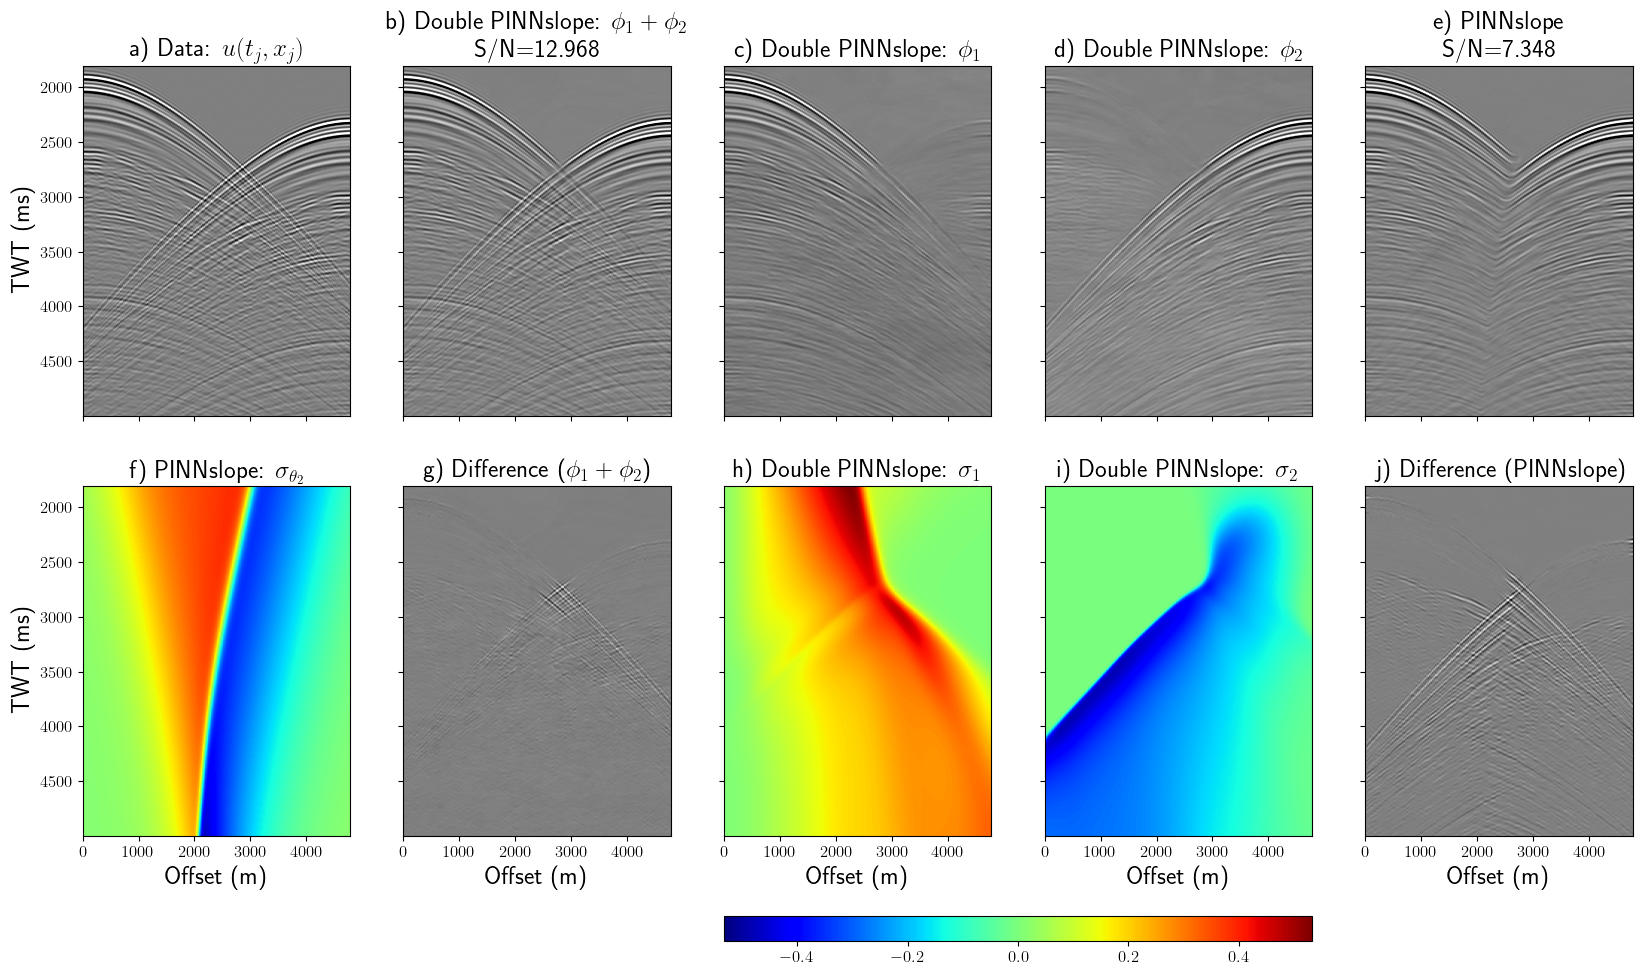

In [4]:
fig, axs = plt.subplots(2, 5, figsize=(20,10), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1]})
vmax=0.5; vmin=-vmax

a_=axs[0][0].imshow(data, cmap='gray',vmin=vmin, vmax=vmax, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[0][0].set_xticklabels([])
axs[0][0].set_ylabel('TWT (ms)')
axs[0][0].set_title('a) Data:' + r' $u(t_{j}, x_{j})$')
axs[0][0].axis('tight')

b_=axs[0][1].imshow(u1u2, cmap='gray',vmin=vmin,vmax=vmax, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[0][1].set_xticklabels([])
axs[0][1].set_yticklabels([])
axs[0][1].set_title('b) Double PINNslope:' +  r' $\phi_{1}+\phi_{2}$'+'\n S/N={}'.format( round(snr(data, u1u2),3) ))
axs[0][1].axis('tight')

c_=axs[0][2].imshow(u1, cmap='gray',vmin=vmin, vmax=vmax, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[0][2].set_xticklabels([])
axs[0][2].set_title('c) Double PINNslope:' + r' $\phi_{1}$')
axs[0][2].set_yticklabels([])
axs[0][2].axis('tight')

d_=axs[0][3].imshow(u2, cmap='gray', vmin=vmin,vmax=vmax, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[0][3].set_xticklabels([])
axs[0][3].set_title('d) Double PINNslope:'+ r' $\phi_{2}$')
axs[0][3].set_yticklabels([])
axs[0][3].axis('tight')

e_=axs[0][4].imshow(pinnslope_u, cmap='gray', vmin=vmin,vmax=vmax, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[0][4].set_xticklabels([])
axs[0][4].set_title('e) PINNslope \n S/N={}'.format( round(snr(data, pinnslope_u),3) ))
axs[0][4].set_yticklabels([])
axs[0][4].axis('tight')

f_=axs[1][0].imshow(pinnslope_slope, cmap='jet', vmin=-np.max(slope1), vmax=np.max(slope1), extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[1][0].set_xlabel('Offset (m)')
axs[1][0].set_ylabel('TWT (ms)')
axs[1][0].set_title('f) '+' PINNslope: '+ r' $\sigma_{\theta_{2}}$')
axs[1][0].axis('tight')

g_=axs[1][1].imshow((data-u1u2), cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[1][1].set_xlabel('Offset (m)')
axs[1][1].set_title('g) '+'Difference ' + '('+r'$\phi_{1}+\phi_{2}$'+')')
axs[1][1].set_yticklabels([])
axs[1][1].axis('tight')

h_=axs[1][2].imshow(slope1, cmap='jet', vmin=-np.max(slope1), vmax=np.max(slope1), extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[1][2].set_xlabel('Offset (m)')
axs[1][2].set_title('h) Double PINNslope: ' +  r' $ \sigma_{1}$')
axs[1][2].set_yticklabels([])
axs[1][2].axis('tight')

i_=axs[1][3].imshow(slope2, cmap='jet', vmin=-np.max(slope1), vmax=np.max(slope1), extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[1][3].set_xlabel('Offset (m)')
axs[1][3].set_yticklabels([])
axs[1][3].set_title('i) Double PINNslope: ' +  r' $ \sigma_{2}$')
axs[1][3].axis('tight')

j_=axs[1][4].imshow((data-pinnslope_u), cmap='gray', vmin=vmin,vmax=vmax, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[1][4].set_xlabel('Offset (m)')
axs[1][4].set_title('j) Difference (PINNslope)')
axs[1][4].set_yticklabels([])
axs[1][4].axis('tight')

cb=axs[1][2].inset_axes([0, -.3, 2.2, .07]) 
fig.colorbar(h_, cax=cb, orientation='horizontal')

plt.show()

In [52]:
# Loading the saved losses
dloss_values = np.load('../data/precomputed_results/deblending/loss_values.npy')
dloss_data_values = np.load('../data/precomputed_results/deblending/loss_data_values.npy')
dloss_phy_values = np.load('../data/precomputed_results/deblending/loss_phy_values.npy')

# Plotting the Loss:
epochs = 2000
n_grid_slope_batches = 61
dlossphy = [dloss_phy_values[ep*n_grid_slope_batches] for ep in range(epochs)]
dlossdata = [dloss_data_values[ep*n_grid_slope_batches] for ep in range(epochs)]
dlosstot = [dloss_values[ep*n_grid_slope_batches] for ep in range(epochs)]

losstot = np.load('../data/precomputed_results/deblending/single_out_pinnslope/losstot.npy')
lossdata = np.load('../data/precomputed_results/deblending/single_out_pinnslope/lossdata.npy')
lossphy = np.load('../data/precomputed_results/deblending/single_out_pinnslope/lossphy.npy')

# # Plotting the Loss:
# epochs = 2000
# n_grid_slope_batches = 61
# lossphy = [loss_phy_values[ep*n_grid_slope_batches] for ep in range(epochs)]
# lossdata = [loss_data_values[ep*n_grid_slope_batches] for ep in range(epochs)]
# losstot = [loss_values[ep*n_grid_slope_batches] for ep in range(epochs)]

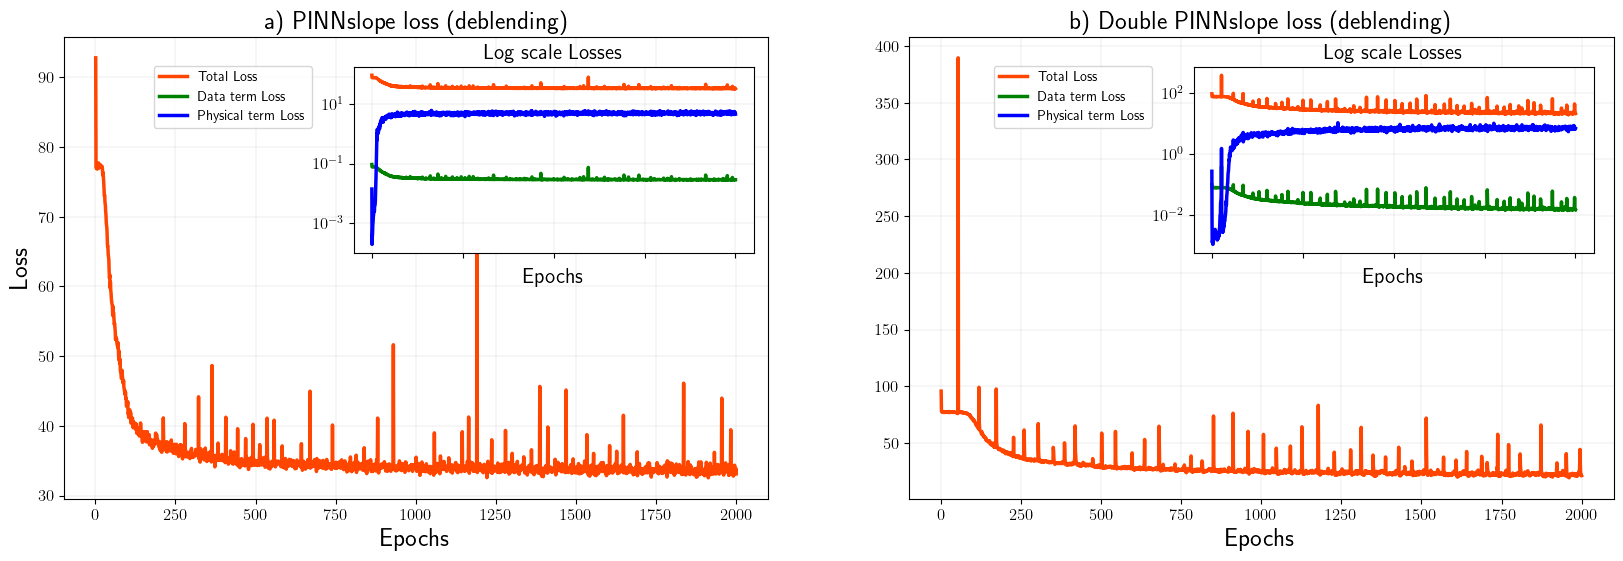

In [53]:
# Plotting the Loss


fig, axs = plt.subplots(1, 2, figsize=(20,6))
# fig.subplots_adjust(wspace=.03)

epochs1 = 2000; epochs_axis1 = np.linspace(1, epochs1, epochs1)
left, bottom, width, height = [0.27, 0.52, 0.2, 0.31]
ax = fig.add_axes([left, bottom, width, height])

ax.plot(epochs_axis1, losstot, '-', color='orangered', linewidth=2.5)
ax.plot(epochs_axis1, lossdata, '-', color='green', linewidth=2.5)
ax.plot(epochs_axis1, lossphy, '-', color='blue', linewidth=2.5)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xlabel('Epochs', fontsize='small')
ax.set_yscale('log')
ax.set_title('Log scale Losses', fontsize='small')
ax.grid(color='grey', linestyle='-', linewidth=0.1)

axs[0].plot(epochs_axis1, losstot, '-', color='orangered', linewidth=2.5)
ax.legend(['Total Loss ', 'Data term Loss', 'Physical term Loss'], loc=( -0.50, 0.67)) # loc = 'upper right')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('a) PINNslope loss (deblending)')
axs[0].grid(color='grey', linestyle='-', linewidth=0.1)
# axs[0].set_yscale('log')


epochs2 = 2000; epochs_axis2 = np.linspace(1, epochs2, epochs2)


# These are in unitless percentages of the figure size. (0,0 is bottom left)
left2, bottom2, width2, height2 = [0.69, 0.52, 0.20, 0.31]
ax2 = fig.add_axes([left2, bottom2, width2, height2])

ax2.plot(epochs_axis2, dlosstot, '-', color='orangered', linewidth=2.5)
ax2.plot(epochs_axis2, dlossdata, '-', color='green', linewidth=2.5)
ax2.plot(epochs_axis2, dlossphy, '-', color='blue', linewidth=2.5)

ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_xlabel('Epochs', fontsize='small')
ax2.set_yscale('log')
ax2.set_title('Log scale Losses', fontsize='small')
ax2.grid(color='grey', linestyle='-', linewidth=0.1)

axs[1].plot(epochs_axis2, dlosstot, '-', color='orangered', linewidth=2.5)
ax2.legend(['Total Loss ', 'Data term Loss', 'Physical term Loss'], loc=( -0.50, 0.67)) # loc = 'upper right')
axs[1].set_xlabel('Epochs')
# axs[1].set_ylabel('Loss',fontsize=15)
axs[1].set_title('b) Double PINNslope loss (deblending)')
axs[1].grid(color='grey', linestyle='-', linewidth=0.1)
# axs[1].set_yscale('log')
# plt.savefig('/home/brandof/Desktop/Figures/deb/deblosses.png', dpi=150, format='png', bbox_inches='tight')

plt.show()


# Interpolation: synthetic data

In [4]:
# Creates a directory to save the results:

# Load the data:
par = interp_synth_data
data = np.load(par['dir']).T
print('Data shape:',data.shape)

# Data dimensions:
ox, dx,  nx = par['ox'], par['dx'], par['nx']
ot, dt, nt = par['ot'], par['dt'], par['nt']
dim_x = int(nx-ox); dim_t = int(nt-ot) 
x = (np.arange(dim_x)+ ox)* dx
x = np.reshape(x, (dim_x, 1) )
t = ((np.arange(dim_t)+ ot) * dt)*1e3
t = np.reshape(t, (dim_t, 1) )

# Subsample factor:
nsub = par['nsub'] # (if set to 1 no subsampling)

# Create restriction operator:
traces_index = np.arange( dim_x )
traces_index_sub = traces_index[::nsub]  
Rop = pylops.Restriction([dim_x, dim_t], 
                         iava=traces_index_sub, 
                         axis=0, 
                         dtype="float64" 
                         )
print('Restriction Op. shape:',Rop.shape)

# Apply restriction Operator to the data:
data_obs, datamask = ROp(Rop, data, traces_index_sub, dim_t)

# Loading pre computed results:
pinnslope_u = np.load('../data/precomputed_results/interpolation/synth/single_out_pinnslope/u1805.npy')[:-250,:]
pinnslope_slope = np.load("../data/precomputed_results/interpolation/synth/single_out_pinnslope/slope1805.npy")[:-250,:]
u1 = np.load("../data/precomputed_results/interpolation/synth/u1.npy")
u2 = np.load('../data/precomputed_results/interpolation/synth/u2.npy')
slope1 = np.load('../data/precomputed_results/interpolation/synth/slope1.npy')
slope2 = np.load("../data/precomputed_results/interpolation/synth/slope2.npy")
u1u2 = u1+u2

Data shape: (300, 900)
Restriction Op. shape: (90000, 270000)
Subsampled data shape: (900, 100)
data_mask shape: (900, 300)


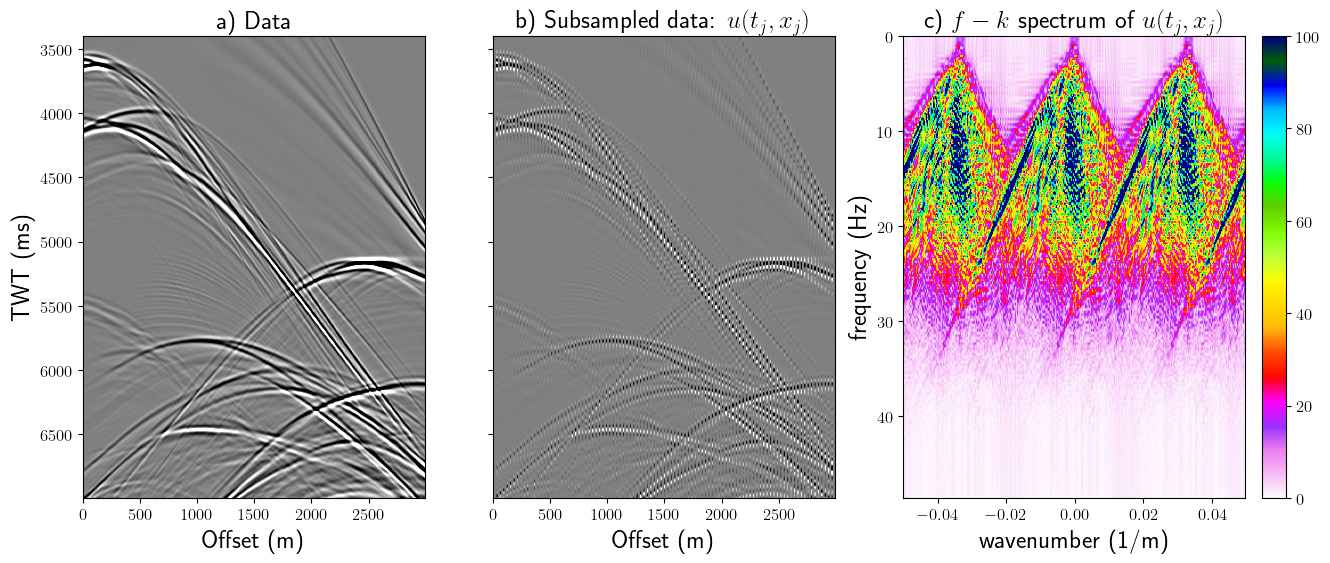

In [5]:
# Display CMP and Trace selected:
fig, axs = plt.subplots(1, 3,  figsize=(15, 6), gridspec_kw={'width_ratios': [1, 1, 1]})
vmin=-.2; vmax=.2
CMP = axs[0].imshow(data.T, cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[0].set_xlabel('Offset (m)')
axs[0].set_ylabel('TWT (ms)')
axs[0].set_title('a) Data')
# fig.colorbar(CMP, ax=axs[0])
axs[0].axis('tight')

CMP1 = axs[1].imshow(datamask, cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[1].set_xlabel('Offset (m)')
# axs[1].set_ylabel('TWT (ms)')
axs[1].set_yticklabels([])
axs[1].set_title('b) Subsampled data: ' + r'$u(t_{j}, x_{j})$')
# fig.colorbar(CMP1, ax=axs[1])
axs[1].axis('tight')

f, kx = np.fft.fftfreq(dim_t, dt), np.fft.fftfreq(dim_x, dx)
FFTsub = np.fft.fft2(datamask[:,:])
limit_plot=175

FFTsubdata=axs[2].imshow(np.fft.fftshift(np.abs(FFTsub[:limit_plot]), axes=1), cmap='gist_ncar_r', vmin=0, vmax=100, extent=(np.fft.fftshift(kx)[0], np.fft.fftshift(kx)[-1], f[limit_plot], f[0]) )
axs[2].set_xlabel('wavenumber (1/m)')
axs[2].set_title('c) '+ r'$f-k$'+' spectrum of '+r'$u(t_{j}, x_{j})$')
axs[2].set_ylabel('frequency (Hz)')
# axs[2].set_yticklabels([])
# fig.colorbar(FFTsubdata, ax=axs[2])
axs[2].axis('tight')

cb=axs[2].inset_axes([1.05, 0, .07, 1]) 
fig.colorbar(FFTsubdata, cax=cb)

# plt.savefig('/home/brandof/Desktop/Figures/interp/intro_interp.png', dpi=80, format='png', bbox_inches='tight')

plt.show()

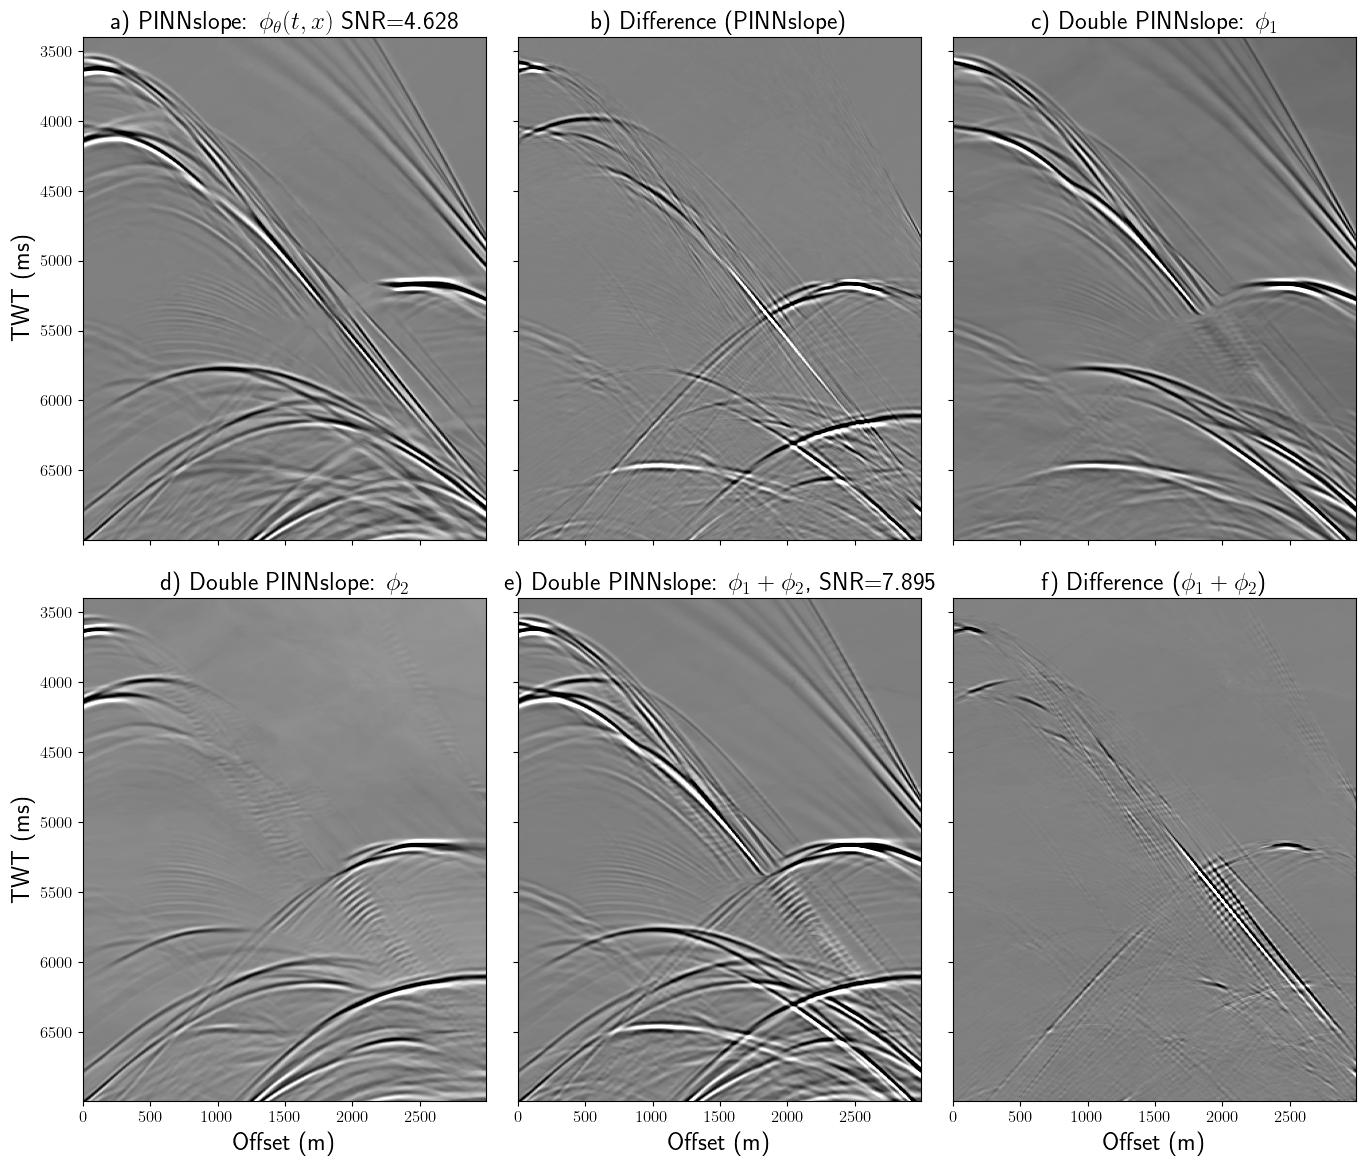

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(14,12), gridspec_kw={'width_ratios': [1, 1, 1]})
vmax=0.2; vmin=-vmax

c_=axs[0][0].imshow(pinnslope_u, cmap='gray',vmin=vmin,vmax=vmax, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
# axs[0][0].set_xlabel('Offset (m)')
axs[0][0].set_ylabel('TWT (ms)')
axs[0][0].set_xticklabels([])
axs[0][0].set_title('a) PINNslope: '+r'$\phi_{\theta}(t,x)$'+' SNR={}'.format( round(snr(data.T, pinnslope_u),3) ))
# axs[0][0].set_yticklabels([])
axs[0][0].axis('tight')

d_=axs[0][1].imshow((data.T-pinnslope_u), cmap='gray', vmin=vmin,vmax=vmax, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
# axs[0][1].set_xlabel('Offset (m)')
axs[0][1].set_xticklabels([])
axs[0][1].set_title('b) Difference (PINNslope)')
axs[0][1].set_yticklabels([])
axs[0][1].axis('tight')

e_=axs[0][2].imshow(u1, cmap='gray',vmin=vmin,vmax=vmax, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
# axs[0][2].set_xlabel('Offset (m)')
axs[0][2].set_xticklabels([])
axs[0][2].set_yticklabels([])
axs[0][2].set_title('c) Double PINNslope: '+r' $\phi_{1}$')
axs[0][2].axis('tight')

f_=axs[1][0].imshow(u2, cmap='gray', vmin=vmin,vmax=vmax, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[1][0].set_xlabel('Offset (m)')
# axs[1][1].set_xticklabels([])
axs[1][0].set_title('d) Double PINNslope: '+r' $\phi_{2}$')
axs[1][0].set_ylabel('TWT (ms)')
axs[1][0].axis('tight')

g_=axs[1][1].imshow(u1u2, cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[1][1].set_xlabel('Offset (m)')
# axs[1][1].set_xticklabels([])
axs[1][1].set_title('e) Double PINNslope: '+r' $\phi_{1}+\phi_{2}$'+', SNR={}'.format( round(snr(data.T, u1u2),3) ))
axs[1][1].set_yticklabels([])
axs[1][1].axis('tight')

h_=axs[1][2].imshow((data.T-u1u2), cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[1][2].set_xlabel('Offset (m)')
axs[1][2].set_title('f) '+'Difference ' + '('+r'$\phi_{1}+\phi_{2}$'+')')
# axs[1][3].set_yticklabels([])
axs[1][2].set_yticklabels([])
axs[1][2].axis('tight')
plt.tight_layout()
# plt.savefig('/home/brandof/Documents/macfb/plots_SSPINN_article/res_synth_interp.png', dpi=300, bbox_inches='tight')
# plt.savefig('/home/brandof/Desktop/Figures/interp/res_synth_interp.png', dpi=80, format='png', bbox_inches='tight')

plt.show()

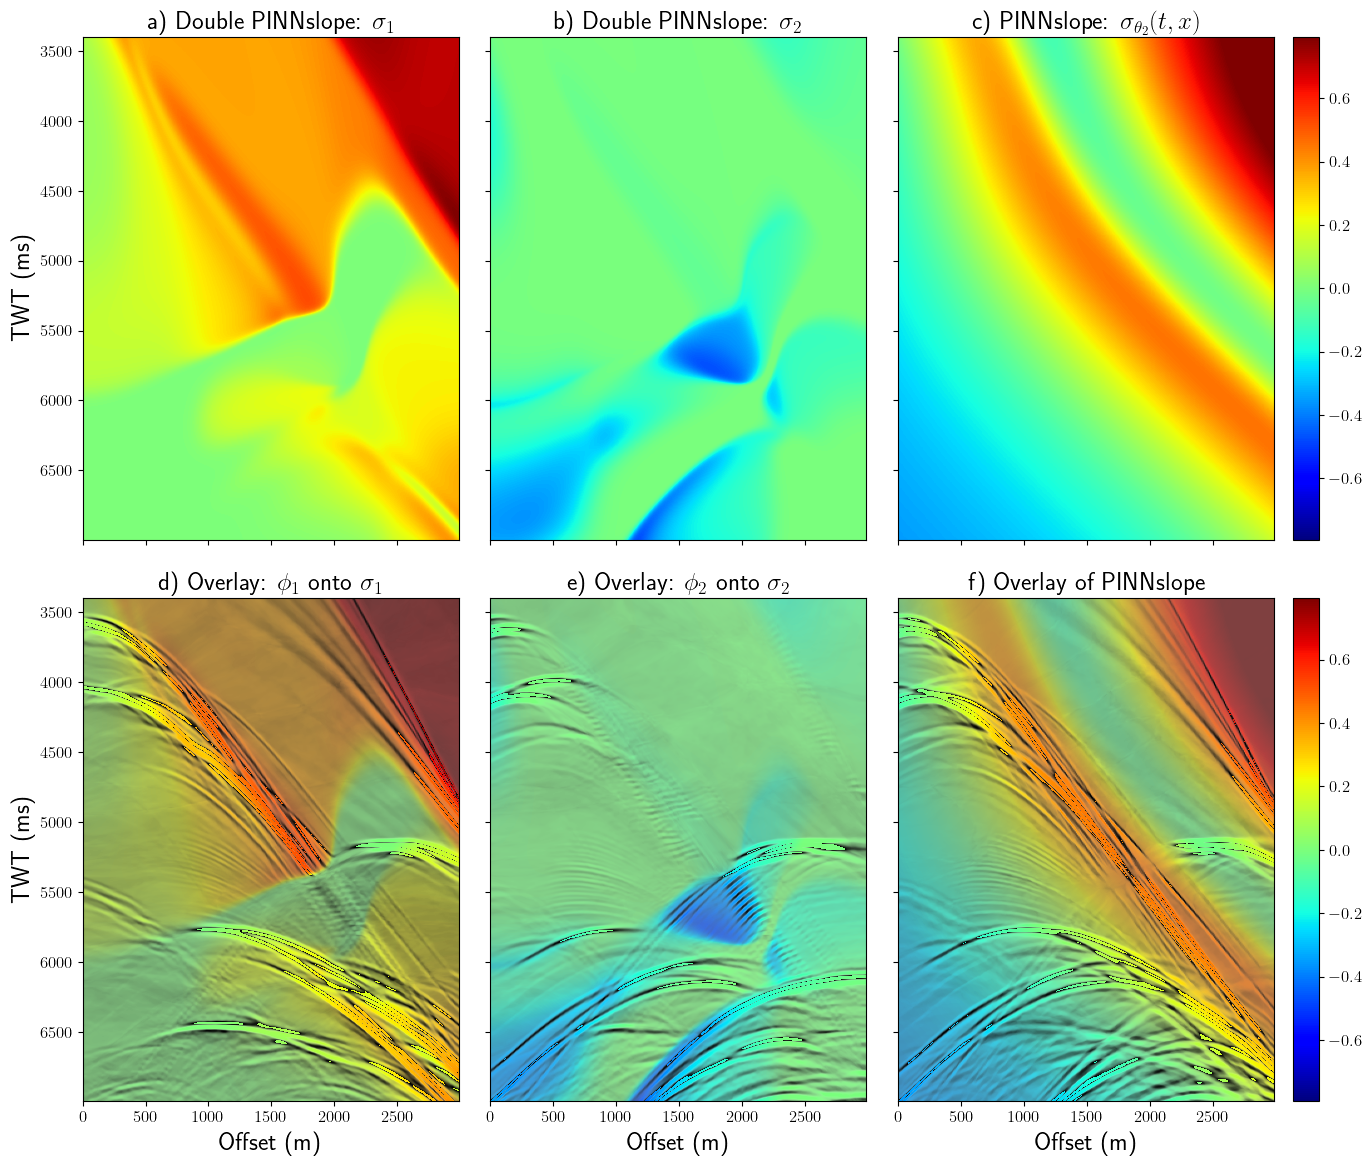

In [8]:
gray= matplotlib.colormaps['gray']

gray._init() # create the _lut array, with rgba values

alphas = np.linspace(1, 0, gray.N+3)
gray._lut[:,-1] = alphas

fig, axs = plt.subplots(2, 3,  figsize=(14, 12))

a_=axs[0][0].imshow(slope1, cmap='jet', vmin=-np.max(slope1), vmax=np.max(slope1), extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
# axs[0][0].set_xlabel('Offset (m)')
axs[0][0].set_xticklabels([])
axs[0][0].set_ylabel('TWT (ms)')
axs[0][0].set_title('a) Double PINNslope: '+r' $ \sigma_{1}$')
# fig.colorbar(i_, ax=axs[2][0])
axs[0][0].axis('tight')

b_=axs[0][1].imshow(slope2, cmap='jet', vmin=-np.max(slope1), vmax=np.max(slope1), extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
# axs[0][1].set_xlabel('Offset (m)')
axs[0][1].set_xticklabels([])
axs[0][1].set_title('b) Double PINNslope: '+r' $ \sigma_{2}$')
axs[0][1].set_yticklabels([])
# fig.colorbar(j_, ax=axs[2][1])
axs[0][1].axis('tight')

c_=axs[0][2].imshow(pinnslope_slope, cmap='jet', vmin=-np.max(slope1), vmax=np.max(slope1), extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
# axs[0][2].set_xlabel('Offset (m)')
axs[0][2].set_xticklabels([])
axs[0][2].set_title('c) '+'PINNslope: ' + r'$\sigma_{\theta_{2}}(t,x)$')
axs[0][2].set_yticklabels([])
# fig.colorbar(k_, ax=axs[2][2])
axs[0][2].axis('tight')
cb=axs[0][2].inset_axes([1.05, 0, .07, 1]) 
fig.colorbar(c_, cax=cb)


d_=axs[1][0].imshow(slope1, cmap='jet', vmin=-np.max(slope1), vmax=np.max(slope1), extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
dd_=axs[1][0].imshow(u1, cmap=gray, vmin=-.1,vmax=.1, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))

axs[1][0].set_xlabel('Offset (m)')
# axs[2][0].set_xticklabels([])
axs[1][0].set_ylabel('TWT (ms)')
axs[1][0].set_title('d) '+'Overlay:' + r' $\phi_{1}$'+' onto'+ r' $ \sigma_{1}$')
# fig.colorbar(i_, ax=axs[2][0])
axs[1][0].axis('tight')

e_=axs[1][1].imshow(slope2, cmap='jet', vmin=-np.max(slope1), vmax=np.max(slope1), extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
ee_=axs[1][1].imshow(u2, cmap=gray, vmin=-.1,vmax=.1, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[1][1].set_xlabel('Offset (m)')
# axs[2][1].set_xticklabels([])
axs[1][1].set_title('e) '+'Overlay:' + r' $\phi_{2}$'+' onto'+ r' $ \sigma_{2}$')
axs[1][1].set_yticklabels([])
# fig.colorbar(j_, ax=axs[2][1])
axs[1][1].axis('tight')

f_=axs[1][2].imshow(pinnslope_slope, cmap='jet', vmin=-np.max(slope1), vmax=np.max(slope1), extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
ff_=axs[1][2].imshow((pinnslope_u), cmap=gray, vmin=-.1,vmax=.1, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[1][2].set_xlabel('Offset (m)')
# axs[2][2].set_xticklabels([])
axs[1][2].set_title('f) '+'Overlay of PINNslope ')
axs[1][2].set_yticklabels([])
# fig.colorbar(k_, ax=axs[2][2])
axs[1][2].axis('tight')

cb=axs[1][2].inset_axes([1.05, 0, .07, 1]) 
fig.colorbar(f_, cax=cb)
plt.tight_layout()
# plt.savefig('/home/brandof/Documents/macfb/plots_SSPINN_article/res_slopeAridSEAM.png', dpi=300, format='png', bbox_inches='tight')
# plt.savefig('/home/brandof/Desktop/Figures/interp/slope_interp.png', dpi=80, format='png', bbox_inches='tight')

plt.show()

In [48]:
losstot = np.load('../data/precomputed_results/interpolation/synth/single_out_pinnslope/loss_values.npy')
lossdata = np.load('../data/precomputed_results/interpolation/synth/single_out_pinnslope/loss_data_values.npy')
lossphy = np.load('../data/precomputed_results/interpolation/synth/single_out_pinnslope/loss_phy_values.npy')
n_grid_slope_batches = 61;  epochs= 2000
lossphy = [lossphy[ep*n_grid_slope_batches] for ep in range(epochs)]
lossdata = [lossdata[ep*n_grid_slope_batches] for ep in range(epochs)]
losstot = [losstot[ep*n_grid_slope_batches] for ep in range(epochs)]

Dlosstot = np.load('../data/precomputed_results/interpolation/synth/loss_values.npy')
Dlossdata = np.load('../data/precomputed_results/interpolation/synth/loss_data_values.npy')
Dlossphy =  np.load('../data/precomputed_results/interpolation/synth/loss_phy_values.npy')

Dlossphy = [Dlossphy[ep*n_grid_slope_batches] for ep in range(epochs)]
Dlossdata = [Dlossdata[ep*n_grid_slope_batches] for ep in range(epochs)]
Dlosstot = [Dlosstot[ep*n_grid_slope_batches] for ep in range(epochs)]

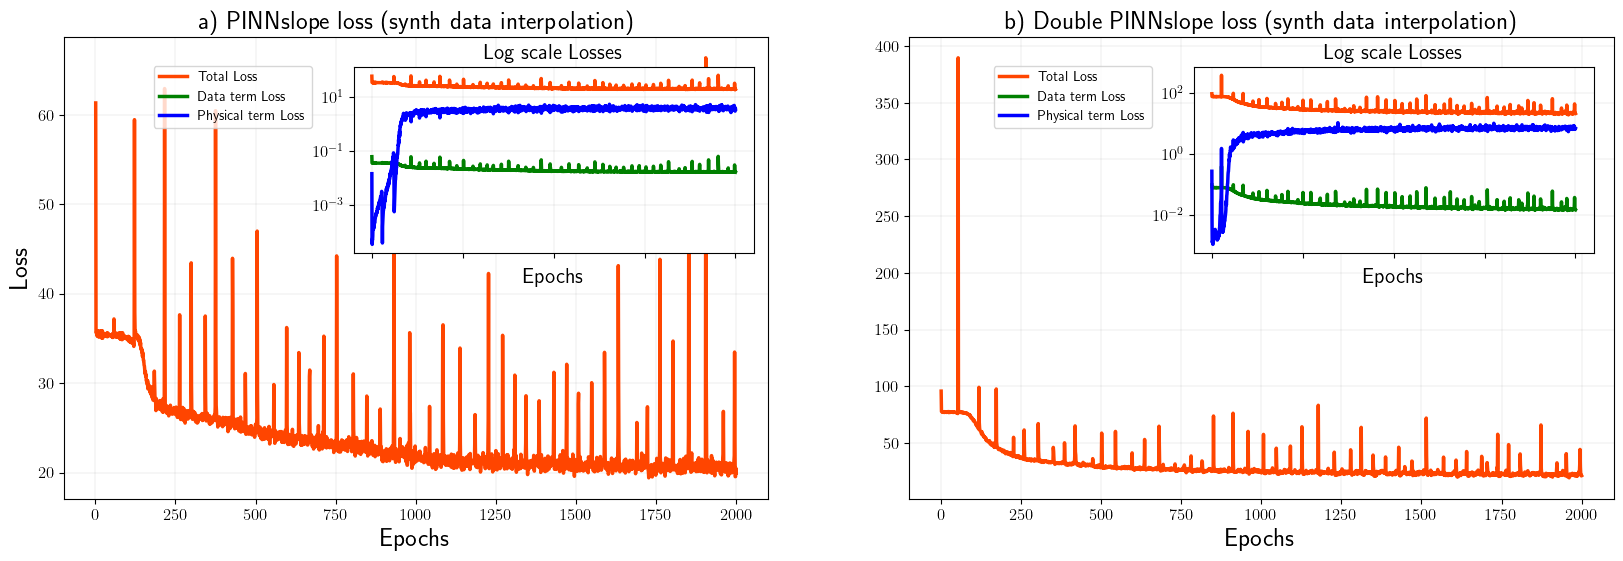

In [49]:
# Plotting the Loss


fig, axs = plt.subplots(1, 2, figsize=(20,6))
# fig.subplots_adjust(wspace=.03)

epochs1 = 2000; epochs_axis1 = np.linspace(1, epochs1, epochs1)
left, bottom, width, height = [0.27, 0.52, 0.2, 0.31]
ax = fig.add_axes([left, bottom, width, height])

ax.plot(epochs_axis1, losstot, '-', color='orangered', linewidth=2.5)
ax.plot(epochs_axis1, lossdata, '-', color='green', linewidth=2.5)
ax.plot(epochs_axis1, lossphy, '-', color='blue', linewidth=2.5)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xlabel('Epochs', fontsize='small')
ax.set_yscale('log')
ax.set_title('Log scale Losses', fontsize='small')
ax.grid(color='grey', linestyle='-', linewidth=0.1)

axs[0].plot(epochs_axis1, losstot, '-', color='orangered', linewidth=2.5)
ax.legend(['Total Loss ', 'Data term Loss', 'Physical term Loss'], loc=( -0.50, 0.67)) # loc = 'upper right')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('a) PINNslope loss (synth data interpolation)')
axs[0].grid(color='grey', linestyle='-', linewidth=0.1)
# axs[0].set_yscale('log')


epochs2 = 2000; epochs_axis2 = np.linspace(1, epochs2, epochs2)


# These are in unitless percentages of the figure size. (0,0 is bottom left)
left2, bottom2, width2, height2 = [0.69, 0.52, 0.20, 0.31]
ax2 = fig.add_axes([left2, bottom2, width2, height2])

ax2.plot(epochs_axis2, dlosstot, '-', color='orangered', linewidth=2.5)
ax2.plot(epochs_axis2, dlossdata, '-', color='green', linewidth=2.5)
ax2.plot(epochs_axis2, dlossphy, '-', color='blue', linewidth=2.5)

ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_xlabel('Epochs', fontsize='small')
ax2.set_yscale('log')
ax2.set_title('Log scale Losses', fontsize='small')
ax2.grid(color='grey', linestyle='-', linewidth=0.1)

axs[1].plot(epochs_axis2, dlosstot, '-', color='orangered', linewidth=2.5)
ax2.legend(['Total Loss ', 'Data term Loss', 'Physical term Loss'], loc=( -0.50, 0.67)) # loc = 'upper right')
axs[1].set_xlabel('Epochs')
# axs[1].set_ylabel('Loss',fontsize=15)
axs[1].set_title('b) Double PINNslope loss (synth data interpolation)')
axs[1].grid(color='grey', linestyle='-', linewidth=0.1)
# axs[1].set_yscale('log')
# plt.savefig('/home/brandof/Desktop/Figures/interp/losses_synth_interp.png', dpi=150, format='png', bbox_inches='tight')

plt.show()


# Interpolation: field data

In [7]:
# Creates a directory to save the results:

# Load the data:
par = interp_field_data
data = np.load(par['dir']).T
print('Data shape:',data.shape)

# Data dimensions:
ox, dx,  nx = par['ox'], par['dx'], par['nx']
ot, dt, nt = par['ot'], par['dt'], par['nt']
dim_x = int(nx-ox); dim_t = int(nt-ot) 
x = (np.arange(dim_x)+ ox)* dx
x = np.reshape(x, (dim_x, 1) )
t = ((np.arange(dim_t)+ ot) * dt)*1e3
t = np.reshape(t, (dim_t, 1) )

# Subsample factor:
nsub = par['nsub'] # (if set to 1 no subsampling)

# Create restriction operator:
traces_index = np.arange( dim_x )
traces_index_sub = traces_index[::nsub]  
Rop = pylops.Restriction([dim_x, dim_t], 
                         iava=traces_index_sub, 
                         axis=0, 
                         dtype="float64" 
                         )
print('Restriction Op. shape:',Rop.shape)

# Apply restriction Operator to the data:
data_obs, datamask = ROp(Rop, data, traces_index_sub, dim_t)

# Loading pre computed results:
pinnslope_u = np.load('../data/precomputed_results/interpolation/field/single_out_pinnslope/u.npy')
pinnslope_slope = np.load("../data/precomputed_results/interpolation/field/single_out_pinnslope/slope.npy")
u1 = np.load("../data/precomputed_results/interpolation/field/u1.npy")
u2 = np.load('../data/precomputed_results/interpolation/field/u2.npy')
slope1 = np.load('../data/precomputed_results/interpolation/field/slope1.npy')
slope2 = np.load("../data/precomputed_results/interpolation/field/slope2.npy")
u1u2 = u1+u2

Data shape: (180, 340)
Restriction Op. shape: (30600, 61200)
Subsampled data shape: (340, 90)
data_mask shape: (340, 180)


In [ ]:
# Display CMP and Trace selected:
fig, axs = plt.subplots(1, 3,  figsize=(15, 6), gridspec_kw={'width_ratios': [1, 1, 1]})
vmin=-.2; vmax=.2
CMP = axs[0].imshow(data.T, cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[0].set_xlabel('Offset (m)')
axs[0].set_ylabel('TWT (ms)')
axs[0].set_title('a) Data')
# fig.colorbar(CMP, ax=axs[0])
axs[0].axis('tight')

CMP1 = axs[1].imshow(datamask, cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[1].set_xlabel('Offset (m)')
# axs[1].set_ylabel('TWT (ms)')
axs[1].set_yticklabels([])
axs[1].set_title('b) Subsampled data: ' + r'$u(t_{j}, x_{j})$')
# fig.colorbar(CMP1, ax=axs[1])
axs[1].axis('tight')

f, kx = np.fft.fftfreq(dim_t, dt), np.fft.fftfreq(dim_x, dx)
FFTsub = np.fft.fft2(datamask[:,:])
limit_plot=150

FFTsubdata=axs[2].imshow(np.fft.fftshift(np.abs(FFTsub[:limit_plot]), axes=1), cmap='gist_ncar_r', vmin=0, vmax=100, extent=(np.fft.fftshift(kx)[0], np.fft.fftshift(kx)[-1], f[limit_plot], f[0]) )
axs[2].set_xlabel('wavenumber (1/m)')
axs[2].set_title('c) '+ r'$f-k$'+' spectrum of '+r'$u(t_{j}, x_{j})$')
axs[2].set_ylabel('frequency (Hz)')
# axs[2].set_yticklabels([])
# fig.colorbar(FFTsubdata, ax=axs[2])
axs[2].axis('tight')

cb=axs[2].inset_axes([1.05, 0, .07, 1]) 
fig.colorbar(FFTsubdata, cax=cb)
# plt.savefig('/home/brandof/Desktop/Figures/interp/intro_field_interp.png', dpi=80, format='png', bbox_inches='tight')

plt.show()

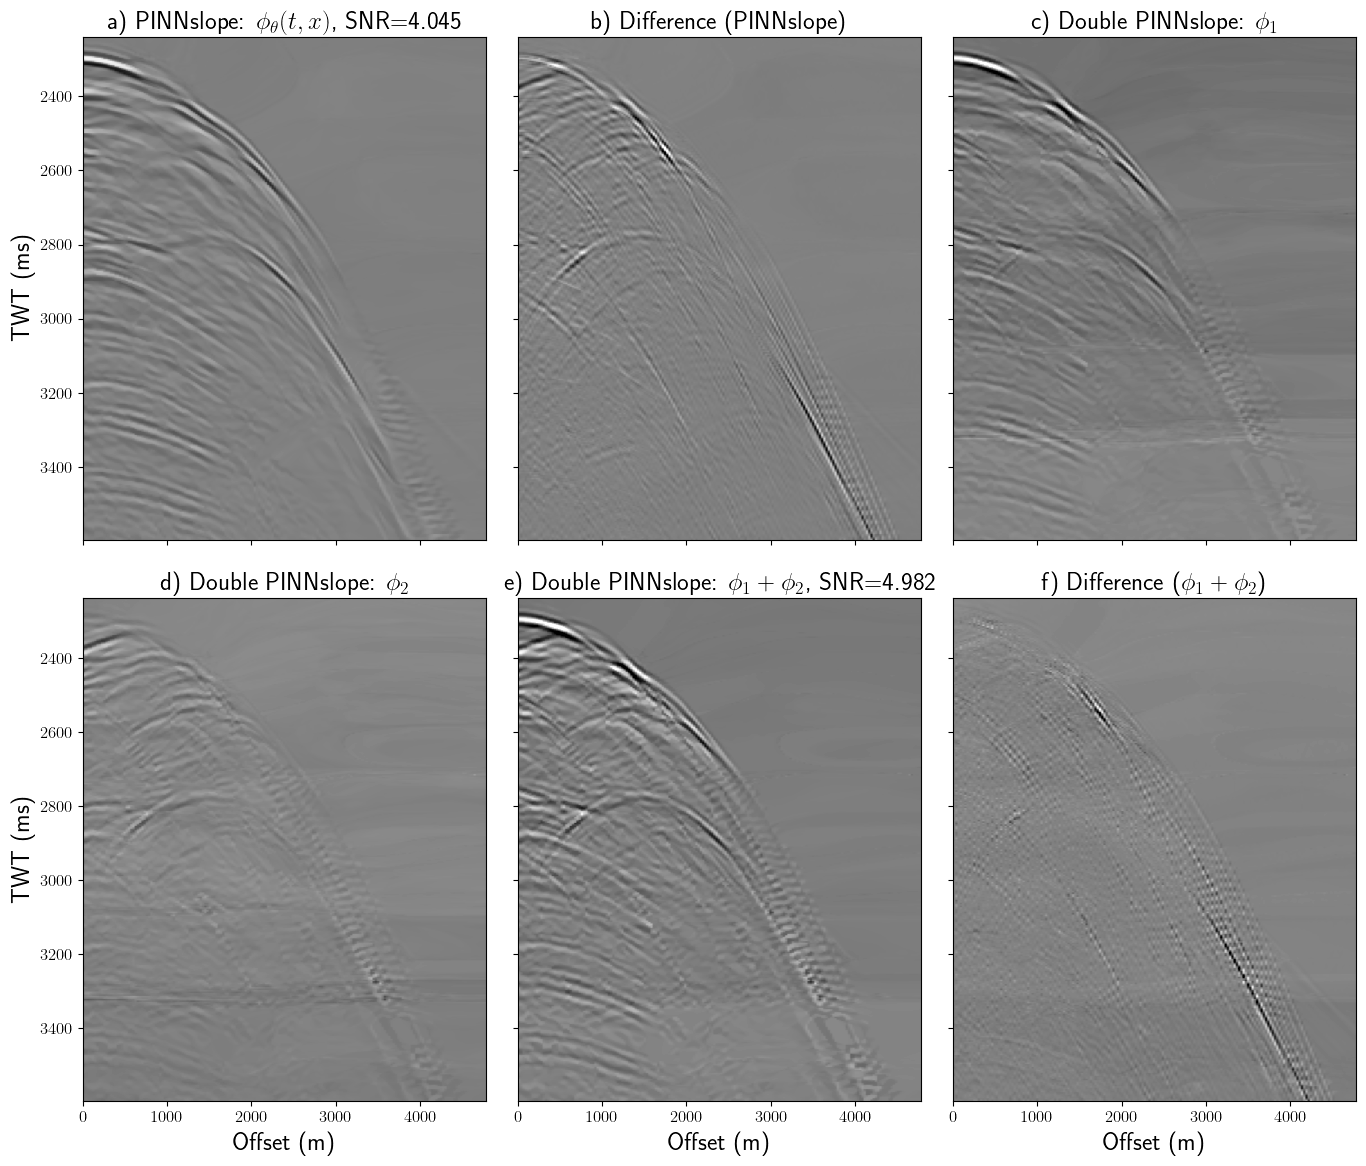

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(14,12), gridspec_kw={'width_ratios': [1, 1, 1]})
vmax=0.5; vmin=-vmax

c_=axs[0][0].imshow(pinnslope_u, cmap='gray',vmin=vmin,vmax=vmax, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
# axs[0][0].set_xlabel('Offset (m)')
axs[0][0].set_ylabel('TWT (ms)')
axs[0][0].set_xticklabels([])
axs[0][0].set_title('a) PINNslope: '+r'$\phi_{\theta}(t,x)$,'+' SNR={}'.format( round(snr(data.T, pinnslope_u),3) ))
# axs[0][0].set_yticklabels([])
axs[0][0].axis('tight')

d_=axs[0][1].imshow((data.T-pinnslope_u), cmap='gray', vmin=vmin,vmax=vmax, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
# axs[0][1].set_xlabel('Offset (m)')
axs[0][1].set_xticklabels([])
axs[0][1].set_title('b) Difference (PINNslope)')
axs[0][1].set_yticklabels([])
axs[0][1].axis('tight')

e_=axs[0][2].imshow(u1, cmap='gray',vmin=vmin,vmax=vmax, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
# axs[0][2].set_xlabel('Offset (m)')
axs[0][2].set_xticklabels([])
axs[0][2].set_yticklabels([])
axs[0][2].set_title('c) Double PINNslope: '+r' $\phi_{1}$')
axs[0][2].axis('tight')

f_=axs[1][0].imshow(u2, cmap='gray', vmin=vmin,vmax=vmax, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[1][0].set_xlabel('Offset (m)')
# axs[1][1].set_xticklabels([])
axs[1][0].set_title('d) Double PINNslope: '+r' $\phi_{2}$')
axs[1][0].set_ylabel('TWT (ms)')
axs[1][0].axis('tight')

g_=axs[1][1].imshow(u1u2, cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[1][1].set_xlabel('Offset (m)')
# axs[1][1].set_xticklabels([])
axs[1][1].set_title('e) Double PINNslope: '+r' $\phi_{1}+\phi_{2}$'+', SNR={}'.format( round(snr(data.T, u1u2),3) ))
axs[1][1].set_yticklabels([])
axs[1][1].axis('tight')

h_=axs[1][2].imshow((data.T-u1u2), cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[1][2].set_xlabel('Offset (m)')
axs[1][2].set_title('f) Difference ' + '('+r'$\phi_{1}+\phi_{2}$'+')')
# axs[1][3].set_yticklabels([])
axs[1][2].set_yticklabels([])
axs[1][2].axis('tight')

plt.tight_layout()
# plt.savefig('/home/brandof/Documents/macfb/plots_SSPINN_article/res_field_interp.png', dpi=300, bbox_inches='tight')
# plt.savefig('/home/brandof/Desktop/Figures/interp/res_field_interp.png', dpi=80, format='png', bbox_inches='tight')

plt.show()

In [6]:
gray= matplotlib.colormaps['gray']

gray._init() # create the _lut array, with rgba values

alphas = np.linspace(1, 0, gray.N+3)
gray._lut[:,-1] = alphas

fig, axs = plt.subplots(2, 3,  figsize=(14, 12))

a_=axs[0][0].imshow(slope1, cmap='jet', vmin=-np.max(slope1), vmax=np.max(slope1), extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
# axs[0][0].set_xlabel('Offset (m)')
axs[0][0].set_xticklabels([])
axs[0][0].set_ylabel('TWT (ms)')
axs[0][0].set_title('a) Double PINNslope: '+r' $ \sigma_{1}$')
# fig.colorbar(i_, ax=axs[2][0])
axs[0][0].axis('tight')

b_=axs[0][1].imshow(slope2, cmap='jet', vmin=-np.max(slope1), vmax=np.max(slope1), extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
# axs[0][1].set_xlabel('Offset (m)')
axs[0][1].set_xticklabels([])
axs[0][1].set_title('b) Double PINNslope: '+r' $ \sigma_{2}$')
axs[0][1].set_yticklabels([])
# fig.colorbar(j_, ax=axs[2][1])
axs[0][1].axis('tight')

c_=axs[0][2].imshow(pinnslope_slope, cmap='jet', vmin=-np.max(slope1), vmax=np.max(slope1), extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
# axs[0][2].set_xlabel('Offset (m)')
axs[0][2].set_xticklabels([])
axs[0][2].set_title('c) '+'PINNslope: ' + r'$\sigma_{\theta_{2}}(t,x)$')
axs[0][2].set_yticklabels([])
# fig.colorbar(k_, ax=axs[2][2])
axs[0][2].axis('tight')

cb=axs[0][2].inset_axes([1.05, 0, .07, 1]) 
fig.colorbar(c_, cax=cb)


d_=axs[1][0].imshow(slope1, cmap='jet', vmin=-np.max(slope1), vmax=np.max(slope1), extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
dd_=axs[1][0].imshow(u1, cmap=gray, vmin=-.3,vmax=.3, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))

axs[1][0].set_xlabel('Offset (m)')
# axs[2][0].set_xticklabels([])
axs[1][0].set_ylabel('TWT (ms)')
axs[1][0].set_title('d) '+'Overlay:' + r' $\phi_{1}$'+' onto'+ r' $ \sigma_{1}$')
# fig.colorbar(i_, ax=axs[2][0])
axs[1][0].axis('tight')

e_=axs[1][1].imshow(slope2, cmap='jet', vmin=-np.max(slope1), vmax=np.max(slope1), extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
ee_=axs[1][1].imshow(u2, cmap=gray, vmin=-.3,vmax=.3, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[1][1].set_xlabel('Offset (m)')
# axs[2][1].set_xticklabels([])
axs[1][1].set_title('e) '+'Overlay:' + r' $\phi_{2}$'+' onto'+ r' $ \sigma_{2}$')
axs[1][1].set_yticklabels([])
# fig.colorbar(j_, ax=axs[2][1])
axs[1][1].axis('tight')

f_=axs[1][2].imshow(pinnslope_slope, cmap='jet', vmin=-np.max(slope1), vmax=np.max(slope1), extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
ff_=axs[1][2].imshow((pinnslope_u), cmap=gray, vmin=-.3,vmax=.3, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[1][2].set_xlabel('Offset (m)')
# axs[2][2].set_xticklabels([])
axs[1][2].set_title('f) '+' Overlay of PINNslope')
axs[1][2].set_yticklabels([])
# fig.colorbar(k_, ax=axs[2][2])
axs[1][2].axis('tight')

cb=axs[1][2].inset_axes([1.05, 0, .07, 1]) 
fig.colorbar(f_, cax=cb)
plt.tight_layout()
# plt.savefig('/home/brandof/Documents/macfb/plots_SSPINN_article/slope_field_interp.png', dpi=300, bbox_inches='tight')
# plt.savefig('/home/brandof/Desktop/Figures/interp/slope_field_interp.png', dpi=80, format='png', bbox_inches='tight')

plt.show()

In [50]:
losstot = np.load('../data/precomputed_results/interpolation/field/single_out_pinnslope/losstot.npy')
lossdata = np.load('../data/precomputed_results/interpolation/field/single_out_pinnslope/lossdata.npy')
lossphy = np.load('../data/precomputed_results/interpolation/field/single_out_pinnslope/lossphy.npy')
n_grid_slope_batches = 61;  epochs= 2000
# lossphy = [lossphy[ep*n_grid_slope_batches] for ep in range(epochs)]
# lossdata = [lossdata[ep*n_grid_slope_batches] for ep in range(epochs)]
# losstot = [losstot[ep*n_grid_slope_batches] for ep in range(epochs)]

Dlosstot = np.load('../data/precomputed_results/interpolation/field/loss_values.npy')
Dlossdata = np.load('../data/precomputed_results/interpolation/field/loss_data_values.npy')
Dlossphy =  np.load('../data/precomputed_results/interpolation/field/loss_phy_values.npy')

Dlossphy = [Dlossphy[ep*n_grid_slope_batches] for ep in range(epochs)]
Dlossdata = [Dlossdata[ep*n_grid_slope_batches] for ep in range(epochs)]
Dlosstot = [Dlosstot[ep*n_grid_slope_batches] for ep in range(epochs)]

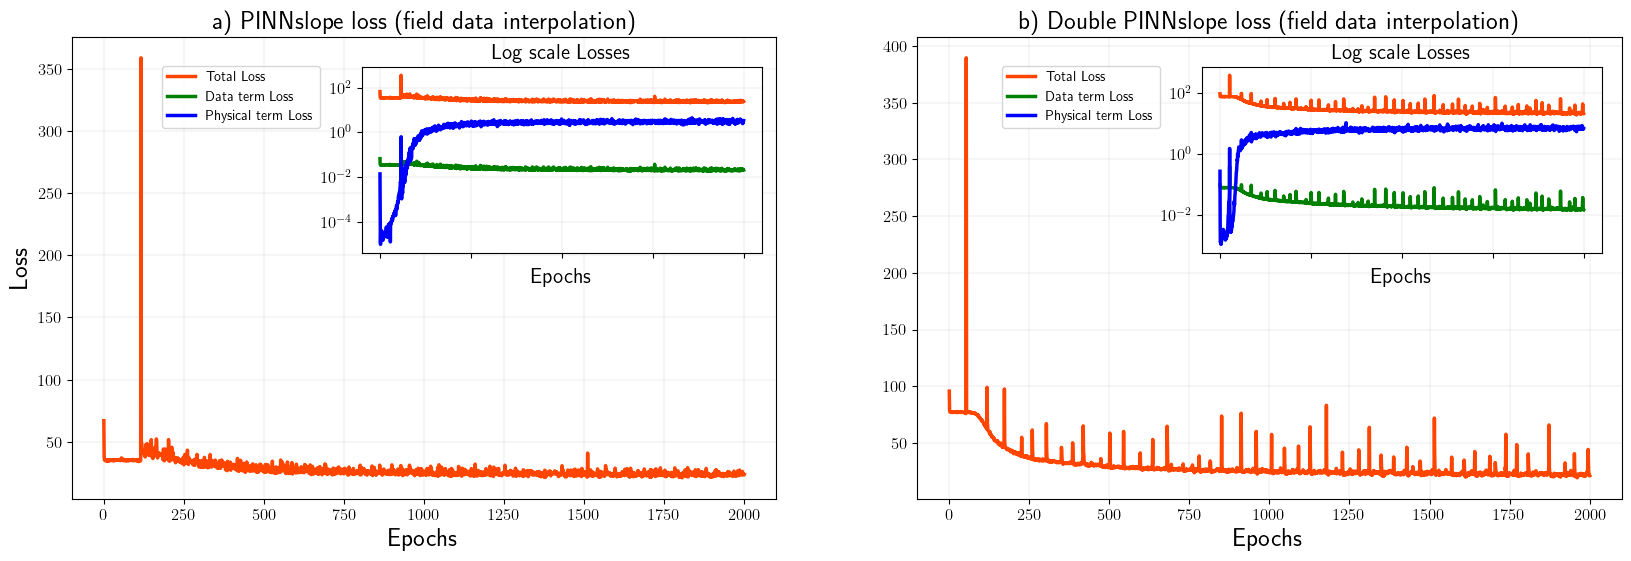

In [51]:
# Plotting the Loss


fig, axs = plt.subplots(1, 2, figsize=(20,6))
# fig.subplots_adjust(wspace=.03)

epochs1 = 2000; epochs_axis1 = np.linspace(1, epochs1, epochs1)
left, bottom, width, height = [0.27, 0.52, 0.2, 0.31]
ax = fig.add_axes([left, bottom, width, height])

ax.plot(epochs_axis1, losstot, '-', color='orangered', linewidth=2.5)
ax.plot(epochs_axis1, lossdata, '-', color='green', linewidth=2.5)
ax.plot(epochs_axis1, lossphy, '-', color='blue', linewidth=2.5)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xlabel('Epochs', fontsize='small')
ax.set_yscale('log')
ax.set_title('Log scale Losses', fontsize='small')
ax.grid(color='grey', linestyle='-', linewidth=0.1)

axs[0].plot(epochs_axis1, losstot, '-', color='orangered', linewidth=2.5)
ax.legend(['Total Loss ', 'Data term Loss', 'Physical term Loss'], loc=( -0.50, 0.67)) # loc = 'upper right')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('a) PINNslope loss (field data interpolation)')
axs[0].grid(color='grey', linestyle='-', linewidth=0.1)
# axs[0].set_yscale('log')


epochs2 = 2000; epochs_axis2 = np.linspace(1, epochs2, epochs2)


# These are in unitless percentages of the figure size. (0,0 is bottom left)
left2, bottom2, width2, height2 = [0.69, 0.52, 0.20, 0.31]
ax2 = fig.add_axes([left2, bottom2, width2, height2])

ax2.plot(epochs_axis2, dlosstot, '-', color='orangered', linewidth=2.5)
ax2.plot(epochs_axis2, dlossdata, '-', color='green', linewidth=2.5)
ax2.plot(epochs_axis2, dlossphy, '-', color='blue', linewidth=2.5)

ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_xlabel('Epochs', fontsize='small')
ax2.set_yscale('log')
ax2.set_title('Log scale Losses', fontsize='small')
ax2.grid(color='grey', linestyle='-', linewidth=0.1)

axs[1].plot(epochs_axis2, dlosstot, '-', color='orangered', linewidth=2.5)
ax2.legend(['Total Loss ', 'Data term Loss', 'Physical term Loss'], loc=( -0.50, 0.67)) # loc = 'upper right')
axs[1].set_xlabel('Epochs')
# axs[1].set_ylabel('Loss',fontsize=15)
axs[1].set_title('b) Double PINNslope loss (field data interpolation)')
axs[1].grid(color='grey', linestyle='-', linewidth=0.1)
# axs[1].set_yscale('log')
# plt.savefig('/home/brandof/Desktop/Figures/interp/loss_field_interp.png', dpi=150, format='png', bbox_inches='tight')

plt.show()
